# Electricity demand


<img src="Hourly-monthly-mean-electricity-demand.png" style="width:600px;height:300px"/>

# Data Preparation & Exploration

In [247]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score

from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [248]:
import fileinput

with fileinput.FileInput("LD_2_2011_2014.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [249]:
import pandas as pd
data = pd.read_csv("LD_2_2011_2014.txt", sep=";", index_col=0)



In [250]:

data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [251]:

print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [252]:
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [253]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0))

(70080, 349)
0


In [254]:
data = data_13_14.copy()



In [255]:
data['hour'] = data.index.map(lambda x: x[11:])
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")


In [256]:
average_curves_norm = average_curves/(average_curves.mean())
#average_curves_norm.index=pd.to_datetime(average_curves_norm.index)


In [257]:
X = average_curves_norm.copy() 



In [258]:
X = np.array(X.T)
X.shape

(349, 96)

# Optimizing k values

In [260]:
wcss=[]
for i in range(3,7):
    kmean=KMeans(i)
    kmean.fit(X)
    wcss_iter=kmean.inertia_
    wcss.append(wcss_iter)


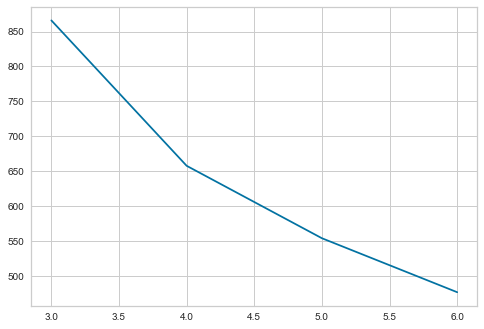

In [262]:
number_cluster=range(3,7)
plt.plot(number_cluster,wcss)
# K optimum is not clear .It seems to be 4, but let's check by other method

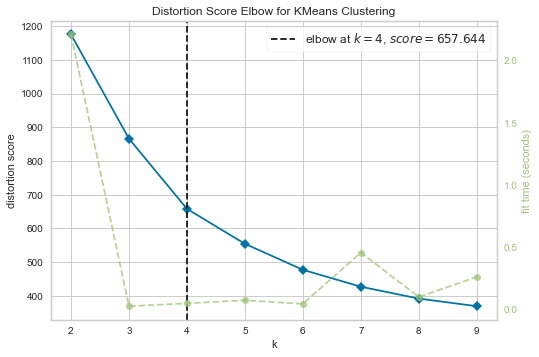

In [263]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(X)        
visualizer.show()
# This visualizer shows k_opt=4, but we want to verify more to be sure.

[0.37191838565388774, 0.42244692513476645, 0.4296355372224772, 0.43445138922045784, 0.42838790129722165, 0.39635138162651284]


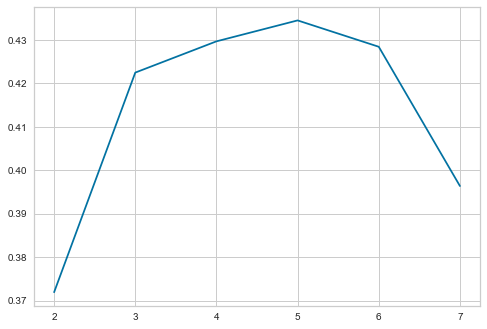

In [266]:
from sklearn.metrics import silhouette_score
n_cluster_list = range(2,8)
sillhoute_scores = []
for i in n_cluster_list:
    
    kmeans = KMeans(n_clusters=i,random_state=42)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
    
number_cluster=range(2,8)

plt.plot(number_cluster,sillhoute_scores)  

print(sillhoute_scores)
#  according to silhouette score, k=5 is chosen as k optimal,as it has a higher score.

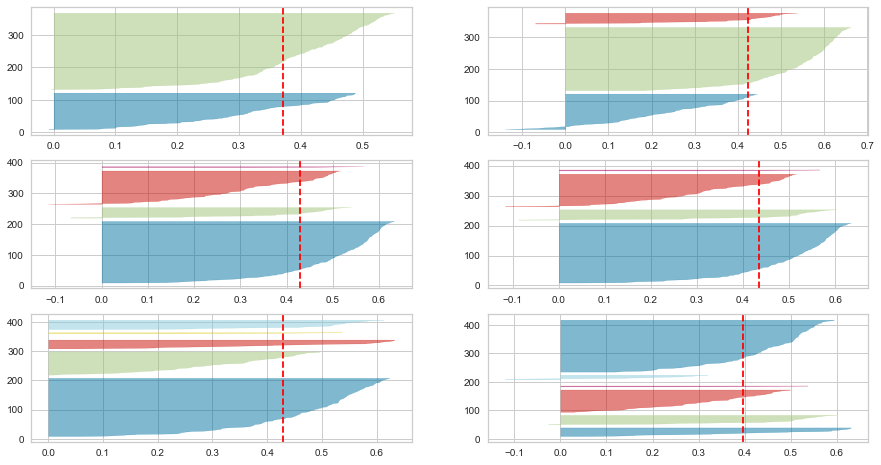

In [272]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    # K=5 is chosen as k_optimal ,as :1- there is no below average like 6,7. 2- less fluctuation.  3-almost uniform thickness.


In [273]:
kmeans=KMeans(n_clusters=5,random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [274]:
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))
print(sum(y_pred==3)) 
print(sum(y_pred==4)) 


200
80
31
1
4


In [275]:
kmeans=KMeans(n_clusters=6,random_state=42)
kmeans.fit(X)
y_pred=kmeans.fit_predict(X)

In [276]:
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))
print(sum(y_pred==3)) 
print(sum(y_pred==4))
print(sum(y_pred==5))

200
80
31
1
4
33


In [277]:
kmeans=KMeans(n_clusters=4,random_state=42)
kmeans.fit(X)
y_pred=kmeans.fit_predict(X)
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))
print(sum(y_pred==3))

201
35
109
4


In [278]:
# As in k=5 & k=6 we have a cluster with just one member,so I want to choose between 4 and 6 . K=4 has more sihouette_score ,so I chose it as optimom_k

In [279]:
kmeans=KMeans(n_clusters=4,random_state=42)
kmeans.fit(X)
y_pred=kmeans.fit_predict(X)


In [280]:
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))
print(sum(y_pred==3)) 


201
35
109
4


In [281]:
data_T=average_curves_norm.transpose()
data_T['cluster'] = pd.Series(y_pred, index=data_T.index)
index_0=data_T[data_T["cluster"]==0].index
index_1=data_T[data_T["cluster"]==1].index
index_2=data_T[data_T["cluster"]==2].index
index_3=data_T[data_T["cluster"]==3].index
# index_0 means the observations that are in cluster 0, index_1 means the observations that are in cluster 1,and so on...

In [282]:
print(sum(data_T["cluster"]==0))
print(sum(data_T["cluster"]==1))
print(sum(data_T["cluster"]==2))
print(sum(data_T["cluster"]==3))

201
35
109
4


In [283]:
cluster=kmeans.cluster_centers_
cluster.shape

(4, 96)

In [284]:
average_curves_norm["cluster_center_0"]=cluster[0].tolist()
average_curves_norm["cluster_center_1"]=cluster[1].tolist()
average_curves_norm["cluster_center_2"]=cluster[2].tolist()
average_curves_norm["cluster_center_3"]=cluster[3].tolist()
index_min=average_curves_norm.index

# Plotting

## Plotting for each cluster for all clients

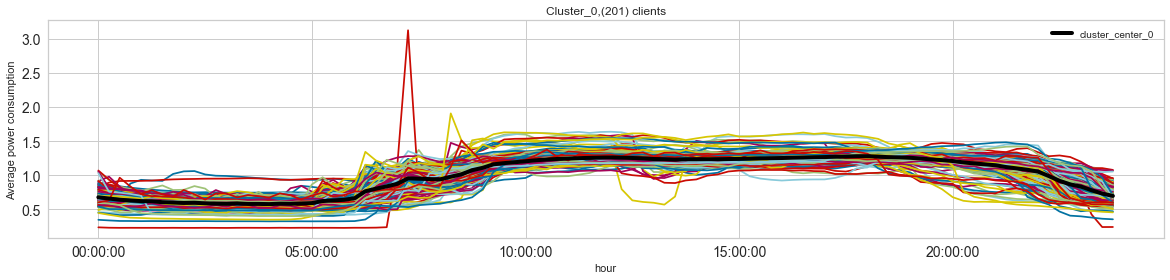

In [286]:
#Cluster==0
ax=average_curves_norm[index_0].plot(kind="line",figsize=(20,4),title="Cluster_0,(201) clients",fontsize="14",legend=False)
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")


average_curves_norm[["cluster_center_0"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)

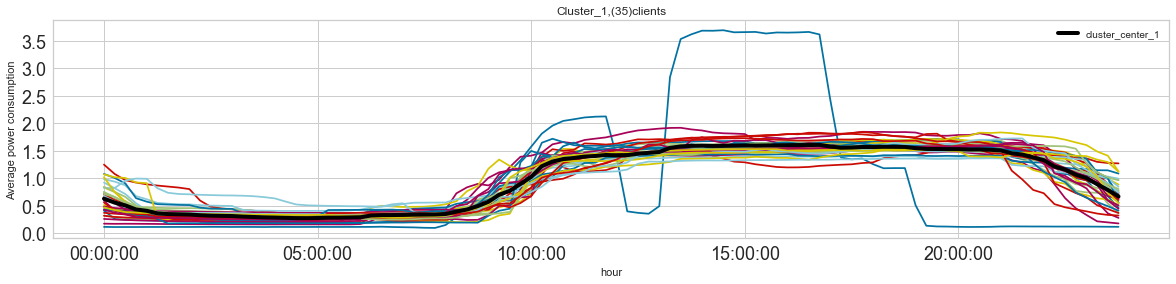

In [288]:
#Cluster==1

ax=average_curves_norm[index_1].plot(kind="line",figsize=(20,4),title="Cluster_1,(35)clients",fontsize="18",legend=False)
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")

average_curves_norm[["cluster_center_1"]].plot(figsize=(20,4),ax=ax,lw=4,color="black")

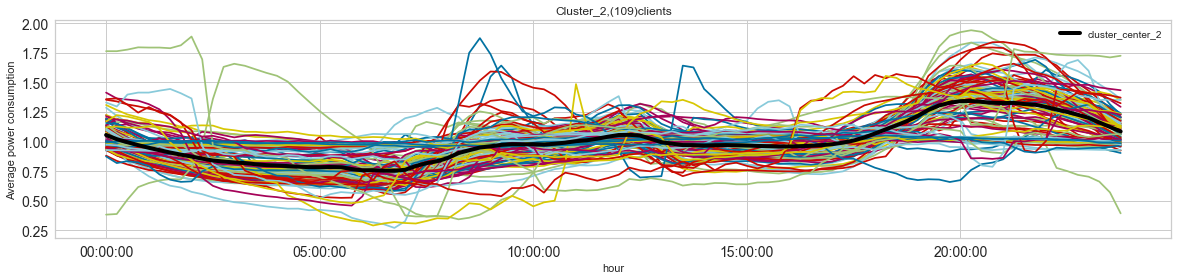

In [289]:
#Cluster==2
ax=average_curves_norm[index_2].plot(kind="line",figsize=(20,4),title="Cluster_2,(109)clients",fontsize="14",legend=False)
                                    
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")

average_curves_norm[["cluster_center_2"]].plot(figsize=(20,4),ax=ax,lw=4,color="black")

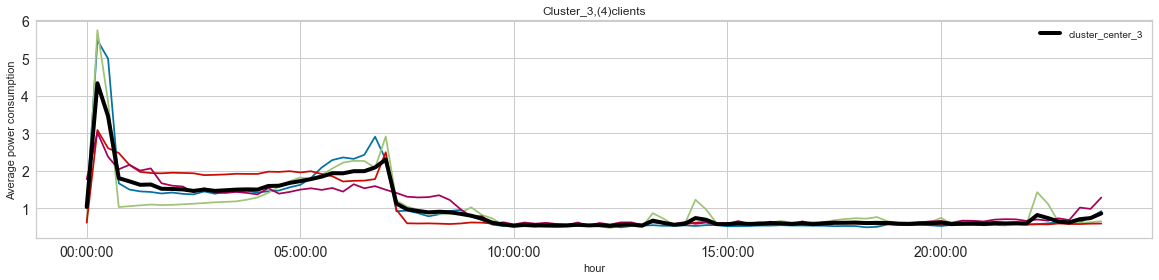

In [290]:
#Cluster==3
ax=average_curves_norm[index_3].plot(kind="line",figsize=(20,4),title="Cluster_3,(4)clients",fontsize="14",legend=False)
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")


average_curves_norm[["cluster_center_3"]].plot(figsize=(20,4),ax=ax,lw=4,color="black")

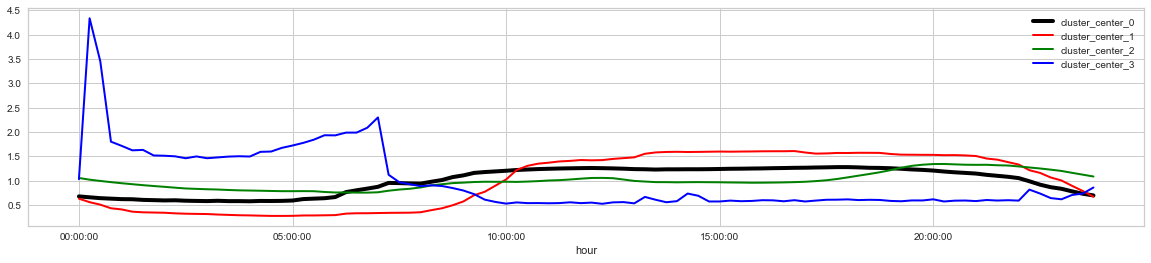

In [291]:
# All center point of clusters:
ax=average_curves_norm[["cluster_center_0"]].plot(kind="line",figsize=(20,4),color="black",lw=4)
average_curves_norm[["cluster_center_1"]].plot(figsize=(20,4),ax=ax,lw=2,color="red")

average_curves_norm[["cluster_center_2"]].plot(figsize=(20,4),ax=ax,lw=2,color="green")

average_curves_norm[["cluster_center_3"]].plot(figsize=(20,4),ax=ax,lw=2,color="blue")

In [292]:
# Interpretation:
# As these are central point of client cluster(each cluster belong to a group of clients) we can get some result interpreting these plots:
# The maximum clients(201) people are in cluster zero(black)that shows around 7am the consumption increases, stables and decrease from 7 pm, that these clients may be business man(may be these items are related to a office or company)
# The red one(35)may be the stores or restaurants that open at 9 am and close around 9 pm.
# The green plot may be people who stay at home.During the night the consumption is lower than day time. Afternoon ,it is getting higher because of using TV.or other electrical devices.
# I do not have an exact idea about the blue spot that its clients work or use electricity at night ,and during the day consumption decreases.
# This kind of clustrification just give us information about the portion of people who are high_consumer during a special time of a day.How much power we need to answer their needs,how should we organize the services during a day.
#This clustering is about daily power consumption in a 15_min interval  on average( average of two years!).It means each plot shows consumption of a client in every 15_min of a day that is a mean of 730 days! 
#However it can roughly give us an overall information about the portion of high-consumer to low_consumer in a specific region ,but there are not any details about time.

## Plotting for one client

In [293]:

from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])
   

In [294]:

client = 'MT_022'
oneClient = data_13_14[client]
X = []
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])
day=pd.DataFrame(X)   
day.columns=index_min
day.index=daysyear
day_norm=day/(day.mean())


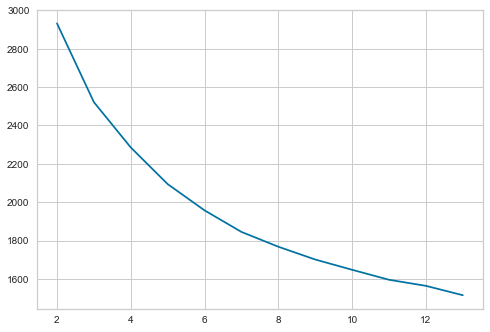

In [295]:
wcss=[]
for i in range(2,14):
    kmean=KMeans(i)
    kmean.fit(day_norm)
    wcss_iter=kmean.inertia_
    wcss.append(wcss_iter)

number_cluster=range(2,14)
plt.plot(number_cluster,wcss,)

[0.4193830813231252, 0.24180445398615272, 0.2143013985201777, 0.17448146637640935, 0.16980415878364868, 0.1694612144869688, 0.17218743554427532, 0.17721579567540277, 0.15788428664831686, 0.15547050924695488, 0.1560348746097446, 0.15962014147156564]


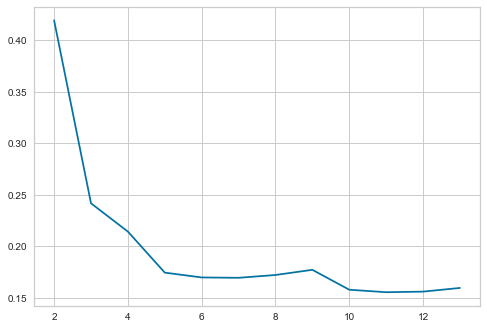

In [296]:
n_cluster_list = range(2,14)
sillhoute_scores = []
for i in n_cluster_list:
    
    kmeans = KMeans(n_clusters=i,random_state=42)
    cluster_found = kmeans.fit_predict(day_norm)
    sillhoute_scores.append(silhouette_score(day_norm, kmeans.labels_))
    
number_cluster=range(2,14)

plt.plot(number_cluster,sillhoute_scores)  

print(sillhoute_scores)

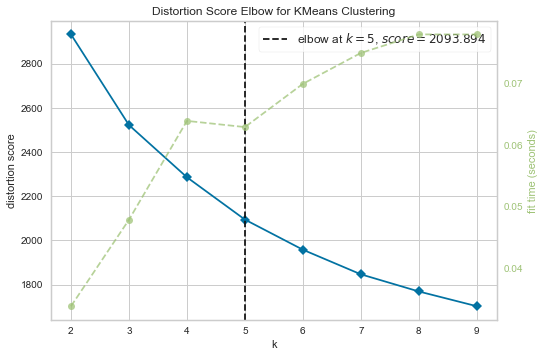

In [297]:

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(day_norm)        
visualizer.show()
# This visulizer sh

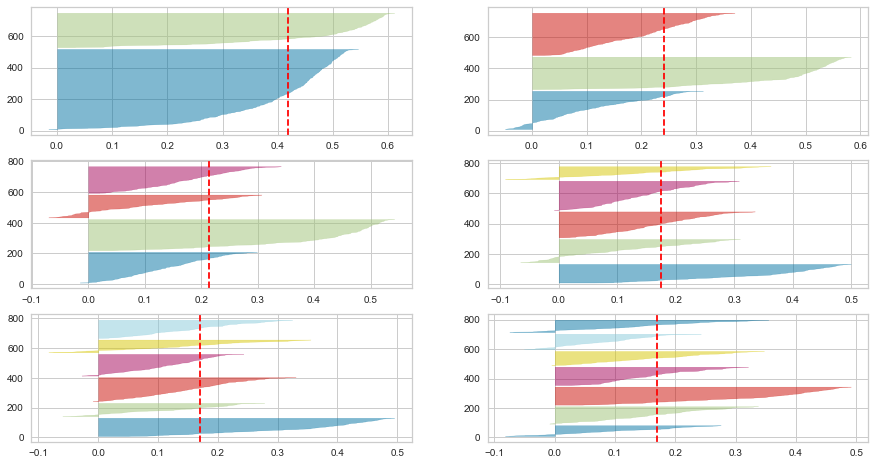

In [298]:

  fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(day_norm)

In [209]:
# It seems 3 and 5 can be k_optimum
#However elbow point shows 5, but according to sillhouette_score I chose 3 that has more score.

In [213]:
kmeans=KMeans(n_clusters=4,random_state=42)
kmeans.fit(day_norm)
y_pred=kmeans.fit_predict(day_norm)
                          
                          

In [214]:
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))
print(sum(y_pred==3))

201
204
150
175


In [300]:
# fit the kmeans for k=3

kmeans=KMeans(n_clusters=3,random_state=42)
kmeans.fit(day_norm)
y_pred=kmeans.fit_predict(day_norm)

In [301]:
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))


247
210
273


In [302]:
y_pred.shape

(730,)

In [303]:
clusters=kmeans.cluster_centers_
clusters[0].shape

(96,)

In [309]:
day_norm['cluster2'] = pd.Series(y_pred, index=day_norm.index)
index_0=day_norm[day_norm["cluster2"]==0].index
index_1=day_norm[day_norm["cluster2"]==1].index
index_2=day_norm[day_norm["cluster2"]==2].index
day_norm
# index_0 means the observations that are in cluster 0, index_1 means the observations that are in cluster 1,and so on...

hour            00:00:00  00:15:00  00:30:00  00:45:00  01:00:00  01:15:00  \
tue-2013-01-01  1.349902  1.280897  1.341015  1.251393  1.243014  1.360671   
wed-2013-01-02  0.971929  1.002441  1.005762  1.032399  1.147398  1.133893   
thu-2013-01-03  0.944931  0.946750  1.005762  1.001114  0.988037  1.069099   
fri-2013-01-04  1.025926  1.002441  1.097194  1.094969  1.147398  1.069099   
sat-2013-01-05  0.863937  0.863213  0.975284  0.969829  0.924293  0.971908   
...                  ...       ...       ...       ...       ...       ...   
sat-2014-12-27  0.917933  0.974596  1.036239  1.032399  1.115526  1.101496   
sun-2014-12-28  1.349902  1.308743  1.371493  1.407817  1.338631  1.295877   
mon-2014-12-29  1.241910  1.336588  1.341015  1.439102  1.370503  1.360671   
tue-2014-12-30  1.268908  1.336588  1.493403  1.439102  1.434247  1.425465   
wed-2014-12-31  1.079922  1.197360  1.158150  1.126254  1.147398  1.198686   

hour            01:30:00  01:45:00  02:00:00  02:15:00  ...  21:45:00  \
tue-2013-01-01  1.375073  1.311181  1.432875  1.277517  ...  0.962553   
wed-2013-01-02  1.047675  1.212842  1.099649  1.143041  ...  0.983943   
thu-2013-01-03  0.949455  0.983386  0.966358  0.941328  ...  1.090893   
fri-2013-01-04  1.113154  1.114504  1.166294  1.176660  ...  0.941163   
sat-2013-01-05  0.949455  0.950606  0.966358  1.042185  ...  1.133673   
...                  ...       ...       ...       ...  ...       ...   
sat-2014-12-27  1.047675  1.048945  1.066326  1.042185  ...  1.326184   
sun-2014-12-28  1.309593  1.343960  1.366230  1.378373  ...  1.326184   
mon-2014-12-29  1.407813  1.376740  1.432875  1.378373  ...  1.176453   
tue-2014-12-30  1.506032  1.442299  1.532843  1.445611  ...  1.155063   
wed-2014-12-31  1.145894  1.147283  1.132971  1.210279  ...  1.197843   

hour            22:00:00  22:15:00  22:30:00  22:45:00  23:00:00  23:15:00  \
tue-2013-01-01  0.945283  0.975966  0.932074  0.989319  1.050016  1.074227   
wed-2013-01-02  0.945283  1.044057  1.001979  0.942209  0.882968  0.924335   
thu-2013-01-03  1.143132  1.202935  1.095186  1.012875  1.073880  1.074227   
fri-2013-01-04  0.989249  0.998663  1.048583  1.012875  1.145472  1.149174   
sat-2013-01-05  0.967266  0.998663  1.141790  1.107096  1.145472  1.224120   
...                  ...       ...       ...       ...       ...       ...   
sat-2014-12-27  1.275032  1.384510  1.398110  1.366203  1.431840  1.423976   
sun-2014-12-28  1.340982  1.180238  1.211696  1.130651  1.264792  1.349030   
mon-2014-12-29  1.121149  1.134844  1.234997  1.248427  1.384112  1.448958   
tue-2014-12-30  0.989249  0.930572  0.978677  1.036430  1.121608  1.199138   
wed-2014-12-31  1.143132  1.202935  1.211696  1.177761  1.312520  1.448958   

hour            23:30:00  23:45:00  cluster2  
tue-2013-01-01  1.020566  1.040038         1  
wed-2013-01-02  1.020566  1.040038         0  
thu-2013-01-03  1.208565  1.120041         0  
fri-2013-01-04  1.154851  1.066706         0  
sat-2013-01-05  1.127994  1.200044         1  
...                  ...       ...       ...  
sat-2014-12-27  1.396564  1.226711         0  
sun-2014-12-28  1.289136  1.120041         1  
mon-2014-12-29  1.396564  1.280047         0  
tue-2014-12-30  1.047423  1.013370         0  
wed-2014-12-31  1.477135  1.333382         1  

[730 rows x 97 columns]

In [319]:

day_norm["day"]=day_norm.index.map(lambda x: x[:-11])

day_norm["date"]=day_norm.index.map(lambda x: x[-10:-3])
day_norm_group=day_norm.groupby(["cluster2","day"])
day_norm_group_da=day_norm.groupby(["cluster2","day"]).count()


In [321]:
day_norm_group=day_norm.groupby(["cluster2","date"])
day_nom_group_cl=day_norm.groupby(["cluster2","date"]).count()

In [322]:
day_norm_T=day_norm.transpose()
day_norm_T.drop([ "cluster2"],inplace=True)
day_norm_T

tue-2013-01-01 wed-2013-01-02 thu-2013-01-03 fri-2013-01-04  \
hour                                                                   
00:00:00         1.3499       0.971929       0.944931        1.02593   
00:15:00         1.2809        1.00244        0.94675        1.00244   
00:30:00        1.34102        1.00576        1.00576        1.09719   
00:45:00        1.25139         1.0324        1.00111        1.09497   
01:00:00        1.24301         1.1474       0.988037         1.1474   
...                 ...            ...            ...            ...   
23:15:00        1.07423       0.924335        1.07423        1.14917   
23:30:00        1.02057        1.02057        1.20856        1.15485   
23:45:00        1.04004        1.04004        1.12004        1.06671   
day                 tue            wed            thu            fri   
date            2013-01        2013-01        2013-01        2013-01   

         sat-2013-01-05 sun-2013-01-06 mon-2013-01-07 tue-2013-01-08  \
hour                                                                   
00:00:00       0.863937        1.18791       0.944931       0.998927   
00:15:00       0.863213        1.14167       0.974596        1.08598   
00:30:00       0.975284        1.18863        1.06672        1.03624   
00:45:00       0.969829        1.18882        1.06368        1.06368   
01:00:00       0.924293        1.17927        1.05178       0.988037   
...                 ...            ...            ...            ...   
23:15:00        1.22412        1.02426       0.899353       0.974299   
23:30:00        1.12799        1.04742       0.966852        1.10114   
23:45:00        1.20004        1.06671         0.9067       0.960035   
day                 sat            sun            mon            tue   
date            2013-01        2013-01        2013-01        2013-01   

         wed-2013-01-09 thu-2013-01-10  ... mon-2014-12-22 tue-2014-12-23  \
hour                                    ...                                 
00:00:00       0.917933       0.944931  ...        1.29591        1.16092   
00:15:00        1.00244       0.863213  ...        1.25305        1.25305   
00:30:00        1.03624       0.944806  ...        1.24958        1.24958   
00:45:00       0.969829        0.90726  ...        1.22011        1.25139   
01:00:00       0.892421       0.860548  ...        1.24301        1.24301   
...                 ...            ...  ...            ...            ...   
23:15:00        1.09921       0.924335  ...        1.22412         1.2491   
23:30:00        1.04742        1.07428  ...        1.20856        1.23542   
23:45:00        1.01337        1.01337  ...        1.12004        1.06671   
day                 wed            thu  ...            mon            tue   
date            2013-01        2013-01  ...        2014-12        2014-12   

         wed-2014-12-24 thu-2014-12-25 fri-2014-12-26 sat-2014-12-27  \
hour                                                                   
00:00:00        1.10692        1.10692        1.02593       0.917933   
00:15:00        1.11382        1.14167        1.03029       0.974596   
00:30:00        1.12767        1.28006        1.12767        1.03624   
00:45:00        1.22011        1.40782        1.15754         1.0324   
01:00:00        1.17927        1.30676        1.17927        1.11553   
...                 ...            ...            ...            ...   
23:15:00        1.27408        1.42398         1.2491        1.42398   
23:30:00        1.15485        1.15485        1.28914        1.39656   
23:45:00        1.06671        1.06671        1.09337        1.22671   
day                 wed            thu            fri            sat   
date            2014-12        2014-12        2014-12        2014-12   

         sun-2014-12-28 mon-2014-12-29 tue-2014-12-30 wed-2014-12-31  
hour                                                                  
00:00:00         1.3499        1.24191        1.26891 

In [323]:
day_norm_T.drop(["day","date"],inplace=True)
day_norm_T["cluster_center_0"]=clusters[0].tolist()
day_norm_T["cluster_center_1"]=clusters[1].tolist()
day_norm_T["cluster_center_2"]=clusters[2].tolist()


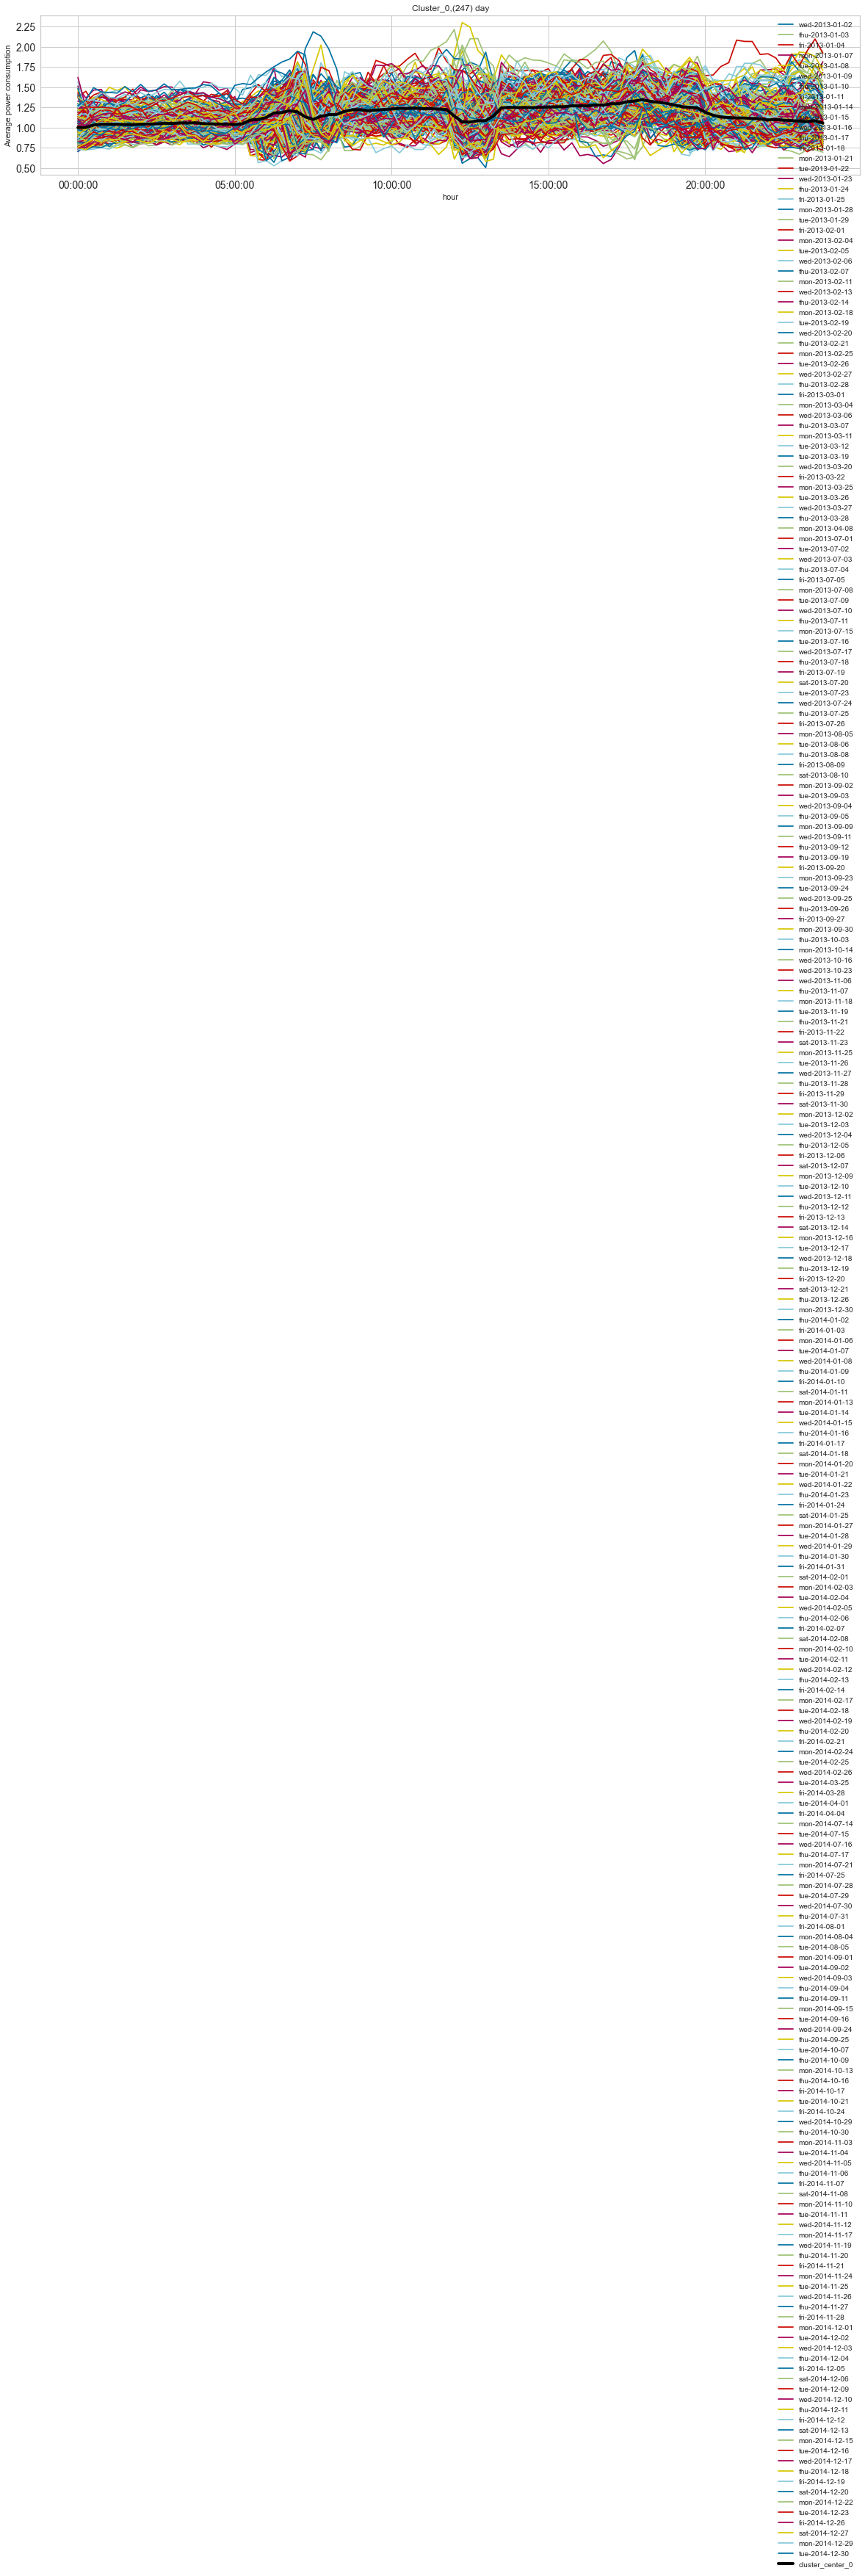

In [324]:
#Cluster 0
ax=day_norm_T[index_0].plot(kind="line",figsize=(20,4),title="Cluster_0,(247) day",fontsize="14")
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")

day_norm_T[["cluster_center_0"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)


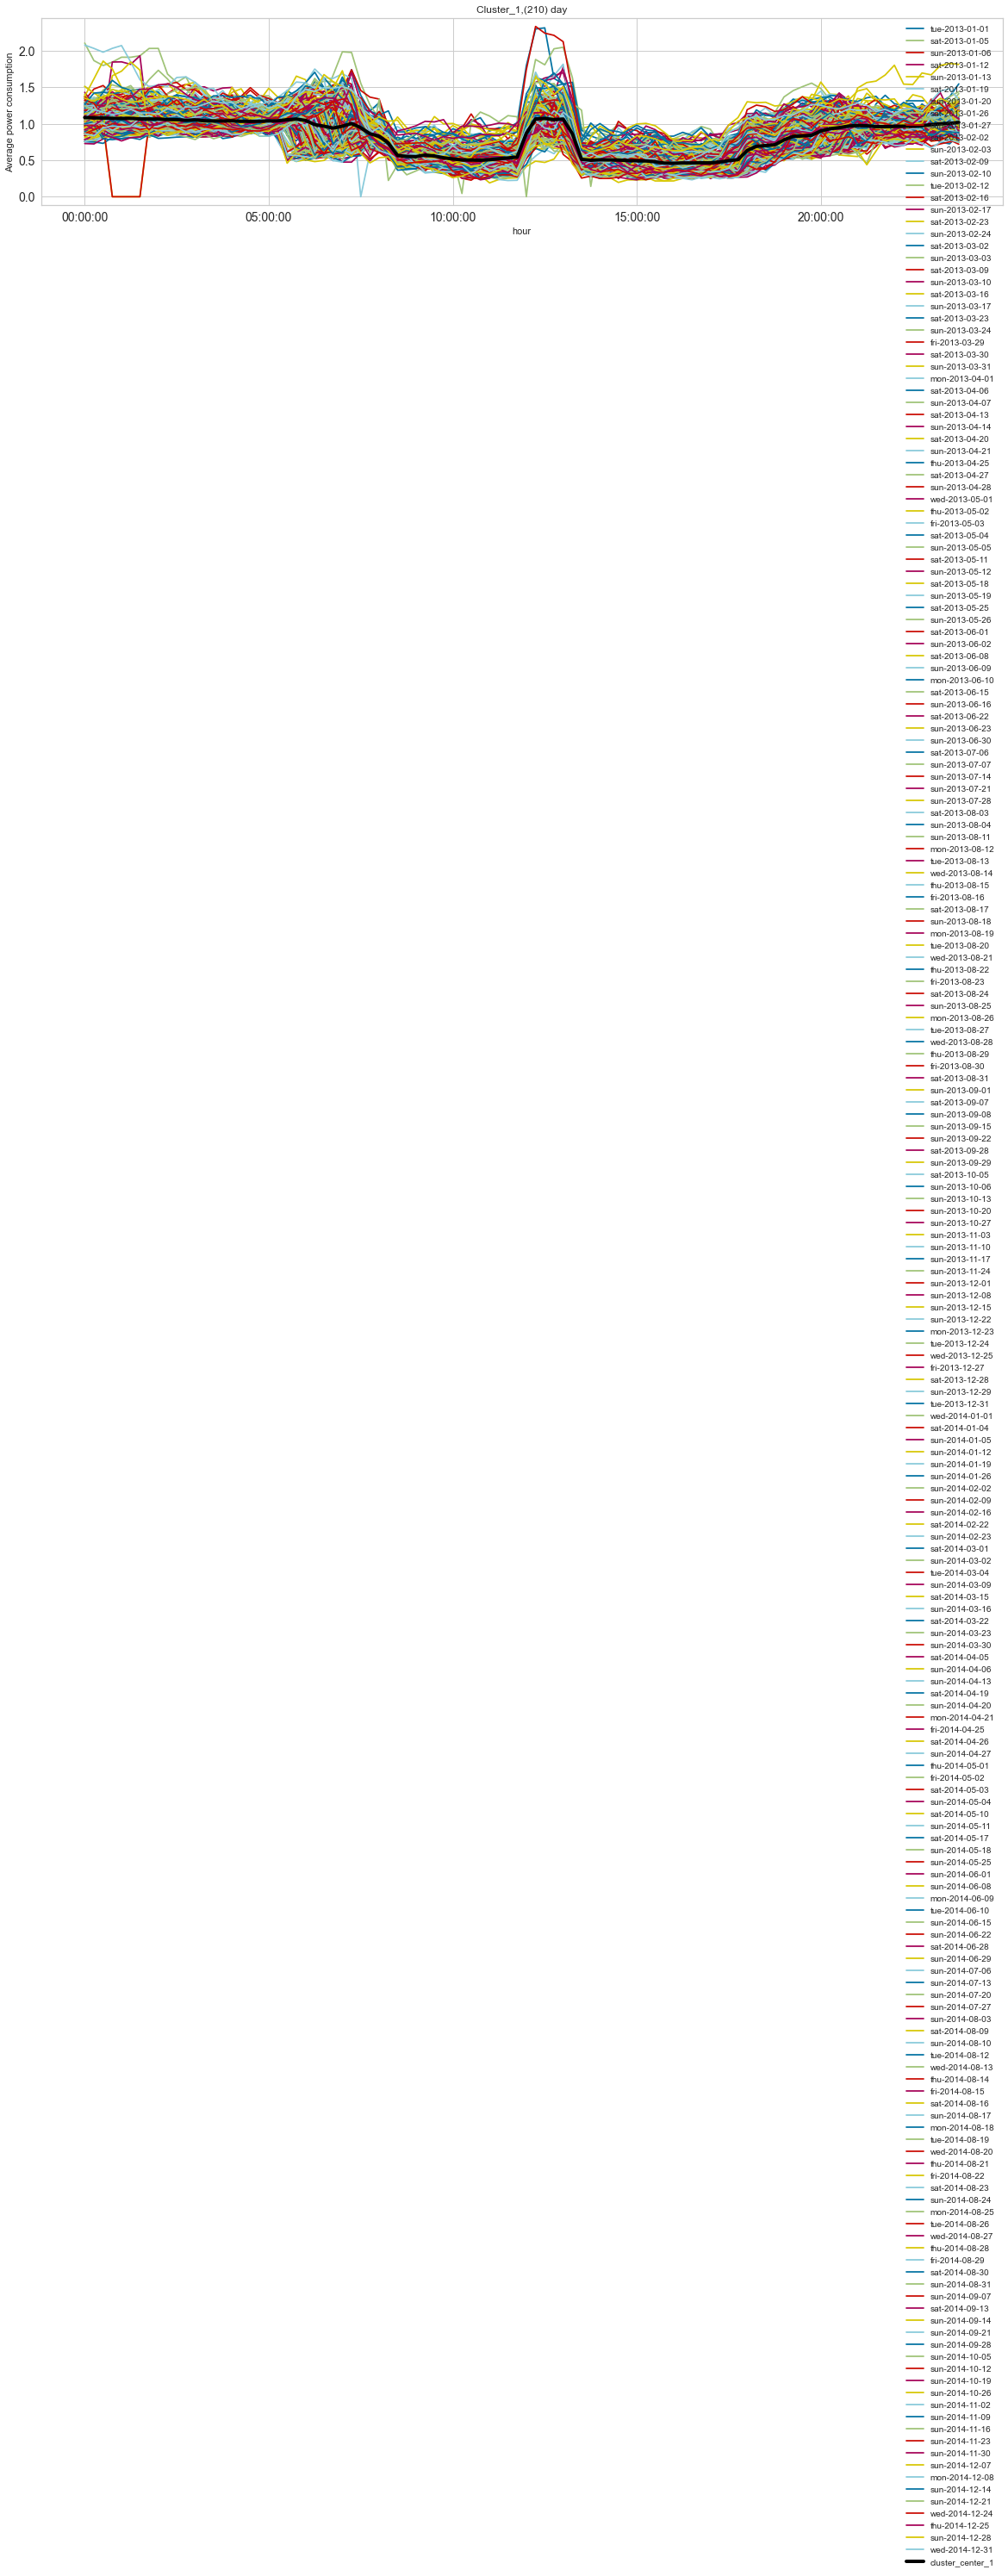

In [325]:
#Cluster 1
ax=day_norm_T[index_1].plot(kind="line",figsize=(20,4),title="Cluster_1,(210) day",fontsize="14")
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")

day_norm_T[["cluster_center_1"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)


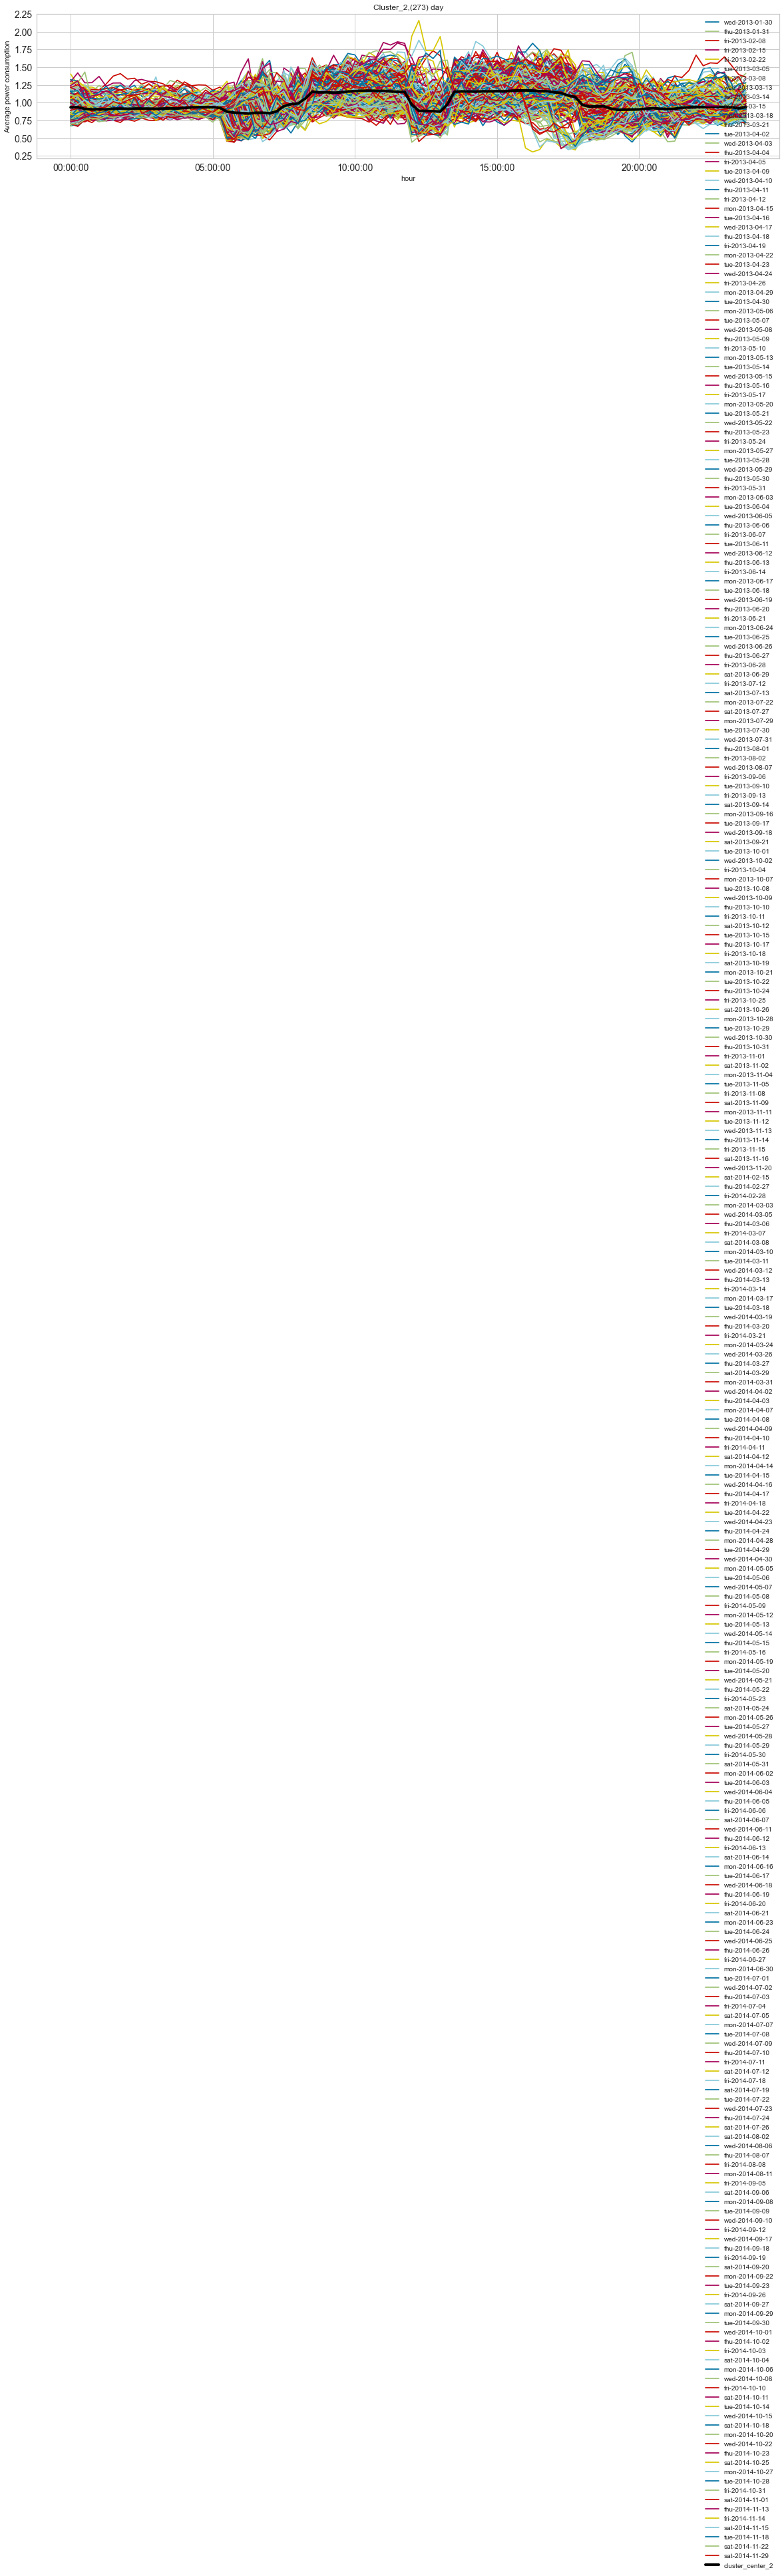

In [326]:
#Cluster 2

ax=day_norm_T[index_2].plot(kind="line",figsize=(20,4),title="Cluster_2,(273) day",fontsize="14")
ax.set_xlabel("Time of a day")
ax.set_ylabel("Average power consumption")

day_norm_T[["cluster_center_2"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)

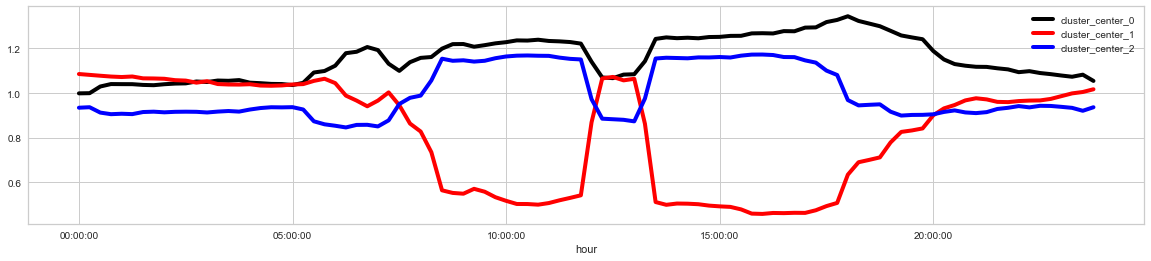

In [327]:
# All centroid clusters
ax=day_norm_T[["cluster_center_0"]].plot(kind="line",figsize=(20,4),color="black",lw=4)
day_norm_T[["cluster_center_1"]].plot(kind="line",figsize=(20,4),ax=ax,color="red",lw=4)
day_norm_T[["cluster_center_2"]].plot(kind="line",figsize=(20,4),ax=ax,color="blue",lw=4)


In [328]:
day_norm_group_da

hour          00:00:00  00:15:00  00:30:00  00:45:00  01:00:00  01:15:00  \
cluster2 day                                                               
0        fri        39        39        39        39        39        39   
         mon        50        50        50        50        50        50   
         sat        17        17        17        17        17        17   
         thu        49        49        49        49        49        49   
         tue        47        47        47        47        47        47   
         wed        45        45        45        45        45        45   
1        fri        11        11        11        11        11        11   
         mon        11        11        11        11        11        11   
         sat        51        51        51        51        51        51   
         sun       104       104       104       104       104       104   
         thu        10        10        10        10        10        10   
         tue        12        12        12        12        12        12   
         wed        11        11        11        11        11        11   
2        fri        54        54        54        54        54        54   
         mon        43        43        43        43        43        43   
         sat        36        36        36        36        36        36   
         thu        45        45        45        45        45        45   
         tue        46        46        46        46        46        46   
         wed        49        49        49        49        49        49   

hour          01:30:00  01:45:00  02:00:00  02:15:00  ...  21:45:00  22:00:00  \
cluster2 day                                          ...                       
0        fri        39        39        39        39  ...        39        39   
         mon        50        50        50        50  ...        50        50   
         sat        17        17        17        17  ...        17        17   
         thu        49        49        49        49  ...        49        49   
         tue        47        47        47        47  ...        47        47   
         wed        45        45        45        45  ...        45        45   
1        fri        11        11        11        11  ...        11        11   
         mon        11        11        11        11  ...        11        11   
         sat        51        51        51        51  ...        51        51   
         sun       104       104       104       104  ...       104       104   
         thu        10        10        10        10  ...        10        10   
         tue        12        12        12        12  ...        12        12   
         wed        11        11        11        11  ...        11        11   
2        fri        54        54        54        54  ...        54        54   
         mon        43        43        43        43  ...        43        43   
         sat        36        36        36        36  ...        36        36   
         thu        45        45        45        45  ...        45        45   
         tue        46        46        46        46  ...        46        46   
         wed        49        49        49        49  ...        49        49   

hour          22:15:00  22:30:00  22:45:00  23:00:00  23:15:00  23:30:00  \
cluster2 day                                                               
0        fri        39        39        39        39        39        39   
         mon        50        50        50        50        50        50   
         sat        17        17        17        17        17        17   
         thu        49        49        49        49        49        49   
         tue        47        47        47        47        47        47   
         wed        45        45        45        45        45        45   
1        fri        11        11        11        11        11        11   
         mon     

In [339]:
day_nom_group_cl.tail(30)

hour              00:00:00  00:15:00  00:30:00  00:45:00  01:00:00  01:15:00  \
cluster2 date                                                                  
1        2014-04         9         9         9         9         9         9   
         2014-05         9         9         9         9         9         9   
         2014-06         8         8         8         8         8         8   
         2014-07         4         4         4         4         4         4   
         2014-08        23        23        23        23        23        23   
         2014-09         5         5         5         5         5         5   
         2014-10         4         4         4         4         4         4   
         2014-11         5         5         5         5         5         5   
         2014-12         8         8         8         8         8         8   
2        2013-01         2         2         2         2         2         2   
         2013-02         3         3         3         3         3         3   
         2013-03         7         7         7         7         7         7   
         2013-04        19        19        19        19        19        19   
         2013-05        20        20        20        20        20        20   
         2013-06        20        20        20        20        20        20   
         2013-07         7         7         7         7         7         7   
         2013-08         3         3         3         3         3         3   
         2013-09         8         8         8         8         8         8   
         2013-10        22        22        22        22        22        22   
         2013-11        13        13        13        13        13        13   
         2014-02         3         3         3         3         3         3   
         2014-03        20        20        20        20        20        20   
         2014-04        19        19        19        19        19        19   
         2014-05        22        22        22        22        22        22   
         2014-06        22        22        22        22        22        22   
         2014-07        17        17        17        17        17        17   
         2014-08         5         5         5         5         5         5   
         2014-09        16        16        16        16        16        16   
         2014-10        18        18        18        18        18        18   
         2014-11         7         7         7         7         7         7   

hour              01:30:00  01:45:00  02:00:00  02:15:00  ...  21:45:00  \
cluster2 date                                             ...             
1        2014-04         9         9         9         9  ...         9   
         2014-05         9         9         9         9  ...         9   
         2014-06         8         8         8         8  ...         8   
         2014-07         4         4         4         4  ...         4   
         2014-08        23        23        23        23  ...        23   
         2014-09         5         5         5         5  ...         5   
         2014-10         4         4         4         4  ...         4   
         2014-11         5         5         5         5  ...         5   
         2014-12         8         8         8         8  ...         8   
2        2013-01         2         2         2         2  ...         2   
         2013-02         3         3         3         3  ...         3   
         2013-03         7         7         7         7  ...         7   
         2013-04        19        19        19        19  ...        19   
         2013-05        20        20        20        20  ...        20   
         2013-06        20        20        20        20  ...        20   
         2013-07         7         7         7         7  ...         7   
         2013-08         3         3         3         3  ...         3   
         2013-

In [ ]:
# Interpretation
# In daily plot clustering that every plot shows 15-min interval of power consumption, we can see in cluster 0 and 2 there is no "Sunday"
#As cluster 0,2 have max consumption of energy it might be the client is a company that is closed on Sundays ,and it works some Saturdays OR a client who works from home.
#Cluster 1 has maximum Sundays and Saturdays ,plus most of the August days(23) are in this cluster that shows the holidays of the company!
# OR we can suppose the client is a person who is out of home on Holidays(all the Sundays and most Saturdays and other holidays )is out of home.
# Cluster 0 are the working days that May and June do not exist and the number of March and April plots are low. Maybe because in this cluster using a conditioner for heating or cooling is important.
#Cluster 2 are working days that client do not use conditioner(for cooling or heating
# In blue and black one from 12 pm to 13 consumption decreases because of lunch break (that work stop)
#I could not understand increasing consumption in 12 to 13 for plot red.May be The clients during holidays are out of house and in lunch time return to home. If the client is not company he/she works at home during weekdays.
#AS a conclusion, these plots that show the amount of consumption for each day can provide more useful information ,because they show consumption according to the factor of time .Time is very important in using power .
# The rate of consuming power on weekends,weekdays in winter ,spring and summer are certainly different.
# If we want to have a more accurate view of the amount of energy of a population of  a specific region,having a cluster of different clients on different datetime(we can have bigger intervals :hourly or 3 times a day)would be a helpful solution.

In [342]:

day_norm.drop(["day","cluster2","date"],axis=1,inplace=True)

In [343]:

day_norm.index=pd.to_datetime(day_norm.index)
day_norm_w=day_norm.resample("W").sum()



In [344]:
day_norm2_w=day_norm_w/(day_norm_w.mean())
day_norm2_w.shape

(105, 96)

In [345]:
kmeans=KMeans(n_clusters=3,random_state=42)
kmeans.fit(day_norm2_w)
y_pred=kmeans.fit_predict(day_norm2_w)


In [346]:
print(sum(y_pred==0))
print(sum(y_pred==1))
print(sum(y_pred==2))

38
23
44


In [347]:
clusters=kmeans.cluster_centers_
clusters.shape

(3, 96)

In [369]:

day_norm2_w['cluster3'] = pd.Series(y_pred,index=day_norm2_w.index)

index_0=day_norm2_w[day_norm2_w["cluster3"]==0].index
index_1=day_norm2_w[day_norm2_w["cluster3"]==1].index
index_2=day_norm2_w[day_norm2_w["cluster3"]==2].index

# index_0 means the observations that are in cluster 0, index_1 means the observations that are in cluster 1,and so on...

In [370]:
day_norm2_w.drop(["cluster3"],axis=1,inplace=True)
day_norm2_w.shape

(105, 96)

In [371]:

day_norm2_w_t=day_norm2_w.transpose()
#day_norm2_w.drop(["2015-01-04"],axis=1,inplace=True)

In [372]:
day_norm2_w_t["cluster_center_0"]=clusters[0].tolist()
day_norm2_w_t["cluster_center_1"]=clusters[1].tolist()
day_norm2_w_t["cluster_center_2"]=clusters[2].tolist()
day_norm2_w_t

2013-01-06 00:00:00  2013-01-13 00:00:00  2013-01-20 00:00:00  \
hour                                                                      
00:00:00             0.912571             0.986353             0.986353   
00:15:00             0.897162             1.025328             0.945224   
00:30:00             0.951278             1.060872             1.052104   
00:45:00             0.940473             1.052970             1.030471   
01:00:00             0.953545             0.976467             1.013142   
...                       ...                  ...                  ...   
22:45:00             0.870737             0.972379             1.016424   
23:00:00             0.895881             0.995423             1.022883   
23:15:00             0.930666             0.998939             0.991753   
23:30:00             0.946433             1.077775             1.054597   
23:45:00             0.939760             1.024147             1.020311   

          2013-01-27 00:00:00  2013-02-03 00:00:00  2013-02-10 00:00:00  \
hour                                                                      
00:00:00             0.986353             0.881504             0.897038   
00:15:00             1.009307             0.897162             0.877136   
00:30:00             1.069639             0.946894             0.938126   
00:45:00             1.034970             0.958473             0.962972   
01:00:00             1.068154             0.971883             0.999389   
...                       ...                  ...                  ...   
22:45:00             1.070633             0.952051             1.016424   
23:00:00             1.026316             0.937071             0.988558   
23:15:00             0.998939             0.973786             0.998939   
23:30:00             1.023693             1.004378             1.039145   
23:45:00             0.978118             0.920582             0.993461   

          2013-02-17 00:00:00  2013-02-24 00:00:00  2013-03-03 00:00:00  \
hour                                                                      
00:00:00             0.955287             0.959170             0.939754   
00:15:00             0.953235             0.917188             0.989281   
00:30:00             1.021418             0.973196             1.043337   
00:45:00             1.021471             0.971972             1.016971   
01:00:00             1.036064             0.985636             1.040648   
...                       ...                  ...                  ...   
22:45:00             1.009648             1.097738             1.033365   
23:00:00             0.937071             1.026316             0.995423   
23:15:00             0.980973             1.013312             0.998939   
23:30:00             1.027556             1.043008             1.035282   
23:45:00             0.985789             1.004968             0.974282   

          2013-03-10 00:00:00  ...  2014-11-23 00:00:00  2014-11-30 00:00:00  \
hour                           ...                                             
00:00:00             0.893154  ...             0.881504             0.834905   
00:15:00             0.929204  ...             0.905172             0.889152   
00:30:00             0.990731  ...             0.916207             0.929359   
00:45:00             0.998971  ...             0.922474             0.935973   
01:00:00             0.985636  ...             0.926039             0.926039   
...                       ...  ...                  ...                  ...   
22:45:00             0.938498  ...             0.935110             0.880901   
23:00:00             0.899314  ...             0.913043             0.875286   
23:15:00             0.923480  ...             0.891140             0.912700   
23:30:00             0.958022  ...             0.942570             0.969611   
23:45:00             0.905239  ...             0.905239             0.897567   

          2014-12-07 00:00:00  2014-12-14

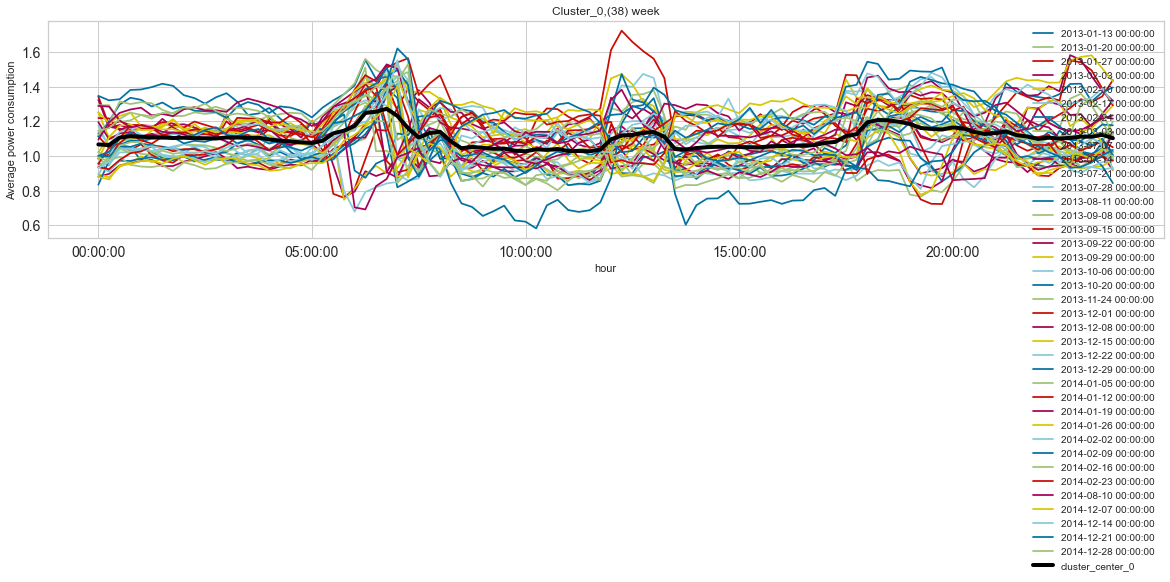

In [373]:
#Cluster 0
ax=day_norm2_w_t[index_0].plot(kind="line",figsize=(20,4),title="Cluster_0,(38) week",fontsize="14")
ax.set_xlabel("Time of a day during a week")
ax.set_ylabel("Average power consumption")

day_norm2_w_t[["cluster_center_0"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)

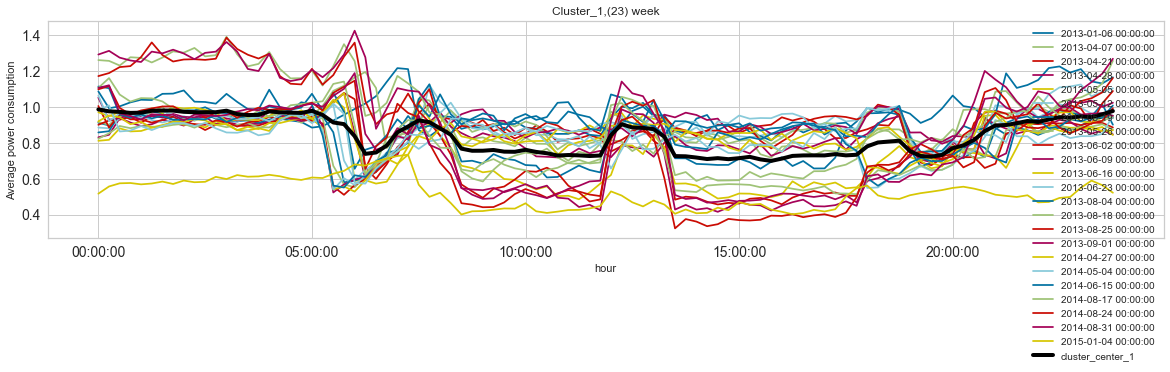

In [374]:
ax=day_norm2_w_t[index_1].plot(kind="line",figsize=(20,4),title="Cluster_1,(23) week",fontsize="14")
ax.set_xlabel("Time of a day during a week")
ax.set_ylabel("Average power consumption")

day_norm2_w_t[["cluster_center_1"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)

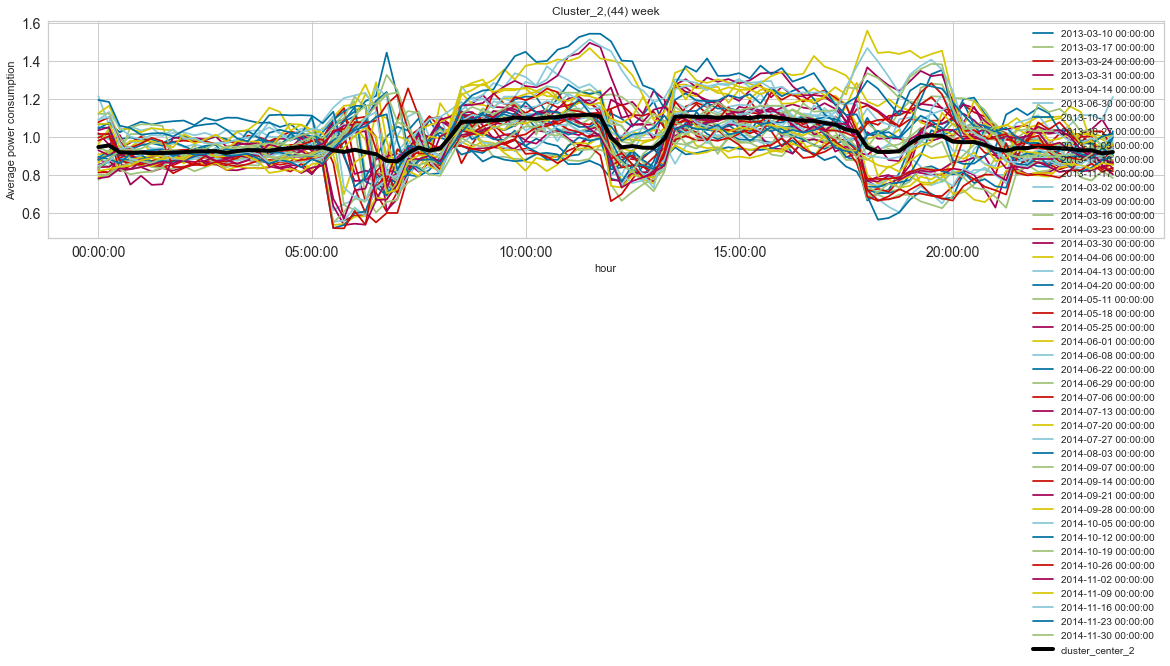

In [375]:
ax=day_norm2_w_t[index_2].plot(kind="line",figsize=(20,4),title="Cluster_2,(44) week",fontsize="14")
ax.set_xlabel("Time of a day during a week")
ax.set_ylabel("Average power consumption")

day_norm2_w_t[["cluster_center_2"]].plot(kind="line",figsize=(20,4),ax=ax,color="black",lw=4)

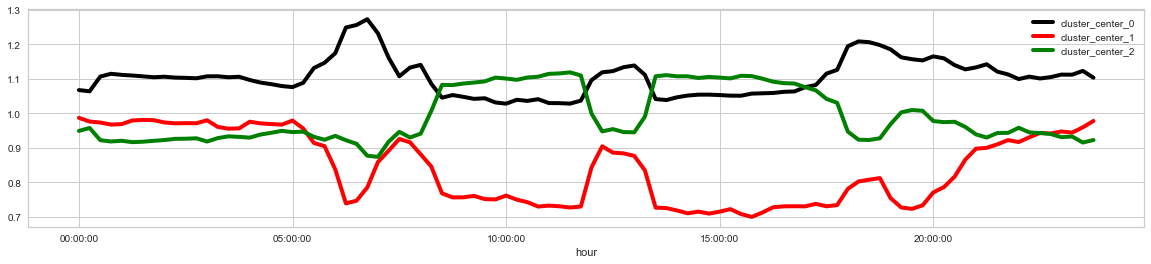

In [376]:
ax=day_norm2_w_t[["cluster_center_0"]].plot(kind="line",figsize=(20,4),color="black",lw=4)
day_norm2_w_t[["cluster_center_1"]].plot(kind="line",figsize=(20,4),ax=ax,color="red",lw=4)


day_norm2_w_t[["cluster_center_2"]].plot(kind="line",figsize=(20,4),ax=ax,color="green",lw=4)

In [381]:
print(index_0.sort_values())
print(index_1.sort_values())
print(index_2.sort_values())

DatetimeIndex(['2013-01-13', '2013-01-20', '2013-01-27', '2013-02-03',
               '2013-02-10', '2013-02-17', '2013-02-24', '2013-03-03',
               '2013-07-07', '2013-07-14', '2013-07-21', '2013-07-28',
               '2013-08-11', '2013-09-08', '2013-09-15', '2013-09-22',
               '2013-09-29', '2013-10-06', '2013-10-20', '2013-11-24',
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02', '2014-02-09', '2014-02-16',
               '2014-02-23', '2014-08-10', '2014-12-07', '2014-12-14',
               '2014-12-21', '2014-12-28'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2013-01-06', '2013-04-07', '2013-04-21', '2013-04-28',
               '2013-05-05', '2013-05-12', '2013-05-19', '2013-05-26',
               '2013-06-02', '2013-06-09', '2013-06-16', '2013-06-23',
               '2013-08-04', '2013-08-18', '2013-08-25'

In [ ]:
# I think weekly clustering does not get good enough information as in a week all weekdays and weekends are mixed together.